# 1. Load libraries

In [1]:
from datetime import datetime as dt
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
sns.set(style="whitegrid")
today = dt.now()

/home/evgenia/mambaforge/envs/arctic-midlat/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Define used parameters

In [2]:
actors = ['PV', 'TAS', 'vflux', 'Sib-SLP', 'Ural-SLP','Aleut-SLP', 'NAO', 'U', 'BK-SIC', 'Ok-SIC']
masking_list = ["OND", "DJF", "JFM"]
pc_alpha_list = [0.01]
max_timelag = 5

## 3. Indicate CMIP6 experiment  
Are you reading CMIP6 scenario data? <br>
Choose **False** if you analyse CMIP6 historical simulations, 
and **True** if you analyse SSP5-8.5 simulations.

In [3]:
SCENARIO = True

if SCENARIO == True: 
    base_folder = "/folder/to/the/dictionary/with/results/from/Tigramite/application/on/data/"
    dict_networks = np.load(base_folder +"/causal_links_scenario_10actors.npy",allow_pickle='TRUE').item()

    #load OBS cauasl graphs
    dict_hist = np.load(base_folder + "causal_links_historical_10actors.npy", allow_pickle='TRUE').item()
    #    dict_hist = np.load("/path/to/the/causal/graphs/causal_links_historical_10actors.npy",allow_pickle='TRUE').item()
    dict_hist_obs = dict_hist["OBS"]
    # Replace each available link with 1, and absence of the link with 0
    for masking in masking_list:
        for pc_element in pc_alpha_list:
            for i in range (0, len (actors)):
                for j in range (0, len (actors)): 
                    for k in range (0, (max_timelag +1)):
                        if dict_hist_obs[masking][pc_element]['results']['graph'][i,j,k] == "":
                            dict_hist_obs[masking][pc_element]['results']['graph'][i,j,k] = 0
                        else:
                            dict_hist_obs[masking][pc_element]['results']['graph'][i,j,k] = 1
else: 
    dict_networks = np.load(base_folder + 'causal_links_historical_10actors.npy',allow_pickle='TRUE').item()

## 4. Data processing
4.1. Sort the output from Tigramite into dictionary **dict_tigramite** with **correlation/autocorrelation** values

In [4]:
# Here fun starts!
dict_tigramite = {}
for key in dict_networks.keys ():
    dict_tigramite.setdefault(key,{})
    for masking in masking_list:
        dict_tigramite[key].setdefault (masking, {})
        for pc_element in pc_alpha_list:
            dict_tigramite[key][masking].setdefault (pc_element, {})
            dict_tigramite[key][masking][pc_element].setdefault('correlation', {})
            dict_tigramite[key][masking][pc_element].setdefault('autocorrelation', {})
            #for the autocorrelation
            test2_list = list ()
            #for the correlation
            vars1 = list ()
            lag_list = list ()
            vvv = list ()
            for i in range (0, len (actors)):
                for j in range (0, len (actors)): 
                    for k in range (0, (max_timelag +1)):
                        #If the connection is detected between two actors: 
                        if dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] != "":
                            # In Galytska et al.,2022 three types of contemporaneos links are summarized in one 
                            # category of "contemporaneous links", thus: 
                            if k==0: 
                                if dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] == 'o-o' or \
                                dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] == 'x-x' or \
                                dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] == '-->' or \
                                dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] == '<--':
                                    dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] = '--'

                            #Lets check the autocorrelation values:
                            if actors[i] == actors[j]:
                                auto = 'autocorrelation'""
                                test2_list.append ([actors[i], k, dict_networks[key][masking][pc_element]['results']['val_matrix'][i,j,k]])
                                dict_tigramite[key][masking][pc_element][auto] = test2_list
                            #Now check instantaneous and causal links
                            else:
                                corr = 'correlation'                               
                                vars1.append (actors[i] + ' '+dict_networks[key][masking][pc_element]['results']['graph'][i,j,k]+ ' '+ actors[j])
                                lag_list.append (k)
                                vvv.append (dict_networks[key][masking][pc_element]['results']['val_matrix'][i,j,k])
                                # Remove duplicates e.g.  PDO--NAO and NAO-- PDO
                                s = list ()
                                skipped = list ()
                                for ind, var in enumerate (vvv):
                                    if var not in s:
                                        s.append (var)
                                    else:
                                        skipped.append (ind)
                                for index in sorted(skipped, reverse=True):
        #                            print (index)
                                    del vvv[index], vars1[index], lag_list[index]

                                testing = list ()
                                for idn in range (0, len (vvv)):
                                    testing.append ([vars1[idn], lag_list[idn],vvv [idn] ])
                                dict_tigramite[key][masking][pc_element][corr] = testing

4.2 Count matches of the same connection betwen the actors among analysed models

In [5]:
fin_dict = {}
# We are dealing with two types of links, i.e. '--' contemporaneous and '-->' causal directed
symbols_list = ['--', '-->']

for masking in masking_list:
    fin_dict.setdefault(masking, {})
    for pc_element in pc_alpha_list:
        fin_dict[masking].setdefault(pc_element, {})

        fin_result_list = list()
        for idx, symbol in enumerate (symbols_list):
            link_matrix_list = list ()
            for key in dict_networks.keys ():
                t = np.zeros ((10,10, 6))
                for i in range (0, 10):
                    for j in range (0, 10): 
                        for k in range (0, (max_timelag +1)):
                            if dict_networks[key][masking][pc_element]['results']['graph'] [i,j,k] == symbol: 
                                t[i,j,k] = 1
                                dict_networks[key][masking][pc_element]['results'].setdefault ('val'+str(idx+1), t)

                            else:
                                t [i,j,k] = 0 
                                dict_networks[key][masking][pc_element]['results'].setdefault ('val'+str(idx+1), t)

                if key != "OBS": 
                    link_matrix=dict_networks[key][masking][pc_element]['results']['val'+str(idx+1)].astype(int)
                    link_matrix_list.append (link_matrix)
                    
            if SCENARIO == False:    
                link_matrix_obs = dict_networks["OBS"][masking][pc_element]['results']['val'+str(idx+1)]
            
            
            my_sum = np.sum(link_matrix_list, axis=0) 
            if SCENARIO == False:
                other_result = my_sum * link_matrix_obs.astype(int) # multiply by obs to show only those links, that are present at observations
            else: 
                other_result = my_sum * dict_hist_obs[masking][pc_element]['results']['graph'].astype(int) # multiply by obs to show only those links, that are present at observations
            fin_result_list.append (other_result)  
        fin_dict[masking][pc_element].setdefault('count_symbol',np.sum (fin_result_list, axis = 0))
            

## 5.  Results

**5.1**. Results from **Fig.4** (for historical) or **Fig. 7** (from Scenario SSP5-8.5 simulations) of *Galytska et al., 2022* are saved in a file below 

In [6]:
path_save_txt=base_folder + '/txt/'+ today.strftime('%d%m%Y') + '/'
for masking in masking_list:
    print ('--------------', masking, '--------------')
    for pc_element in pc_alpha_list:
        print (pc_element)
        filewr=path_save_txt+'obs_vs_models_'+str(masking) + "_"+str (pc_element)+ '.txt'
        fhand=open(filewr,'w+')
        for i in range (0, len (actors)):
            for j in range (0, len (actors)): 
                for k in range (0, (max_timelag +1)):

                    if fin_dict[masking][0.01]['count_symbol'][i,j,k] > 0 and i!=j: 
                        print (actors[i],   actors[j], ', lag:', k,  ', #models', fin_dict[masking][pc_element]['count_symbol'][i,j,k])
                        fhand.write('{0:>10}{1:>10}{2:>3d}{3:4d}\n'.format (str (actors[i]), str (actors[j]), k, fin_dict[masking][pc_element]['count_symbol'][i,j,k]))                
        fhand.close() 

-------------- OND --------------
0.01
PV vflux , lag: 0 , #models 19
PV NAO , lag: 0 , #models 2
TAS BK-SIC , lag: 0 , #models 16
vflux PV , lag: 0 , #models 19
vflux Aleut-SLP , lag: 0 , #models 13
Sib-SLP Ural-SLP , lag: 0 , #models 19
Ural-SLP PV , lag: 1 , #models 3
Ural-SLP Sib-SLP , lag: 0 , #models 19
Aleut-SLP vflux , lag: 0 , #models 13
NAO PV , lag: 0 , #models 2
NAO U , lag: 0 , #models 19
U NAO , lag: 0 , #models 19
BK-SIC TAS , lag: 0 , #models 16
BK-SIC Ok-SIC , lag: 2 , #models 4
-------------- DJF --------------
0.01
PV vflux , lag: 0 , #models 19
PV vflux , lag: 1 , #models 5
PV NAO , lag: 0 , #models 2
TAS Sib-SLP , lag: 0 , #models 5
vflux PV , lag: 0 , #models 19
vflux PV , lag: 1 , #models 18
vflux Aleut-SLP , lag: 0 , #models 16
Sib-SLP TAS , lag: 0 , #models 5
Sib-SLP Ural-SLP , lag: 0 , #models 19
Ural-SLP Sib-SLP , lag: 0 , #models 19
Aleut-SLP vflux , lag: 0 , #models 16
Aleut-SLP Ok-SIC , lag: 1 , #models 1
NAO PV , lag: 0 , #models 2
NAO U , lag: 0 , #model

**5.2** Reproduce Summary plots (**Fig.5**, **S2**, **S3**, **S5-S7**) from *Galytska et al.,2022, JGR*. <br>

**5.2.1** Check all possible links from all data sources 


In [7]:
all_possible_links = list ()
skipped = list ()
for key in dict_tigramite.keys ():
    for masking in masking_list:
        for pc_element in pc_alpha_list:
            for link in dict_tigramite[key][masking][pc_element]['correlation']:
                if link[0] not in all_possible_links:
                    all_possible_links.append (link[0])
                else:
                    skipped.append (link[0])
#Sort alphabetically
sorted_links = sorted (all_possible_links)

Uncomment the code below to check what are the most frequesnt connections from analysed data sources

In [8]:
#print ('Check the most frequent links (not sorted)')
#(({i:skipped.count(i) for i in skipped}))

**5.2.2** Prepare data for plotting 


In [9]:
correlation_dict = {}    
for masking in masking_list:
    lll = list ()
    correlation_dict.setdefault(masking, {})

    for key in dict_tigramite.keys ():
        for pc_element in pc_alpha_list:
            correlation_dict[masking].setdefault (pc_element, {})
            tr = defaultdict(list) 

            for link, lag, cross_mci in dict_tigramite[key][masking][pc_element]['correlation']: 
                tr[link].append ([lag,cross_mci])
            lll.append (tr)
            correlation_dict[masking][pc_element].setdefault ('plotting', lll)


**5.2.3** Define the order of appeared link (see **Fig.5** *Galytska et al.,2022* from bottom to top)


In [10]:
ordered_links = [ 'TAS -- BK-SIC', 'TAS --> BK-SIC', 'TAS --> Ok-SIC', 'TAS --> Aleut-SLP', 'TAS -- Sib-SLP', 
                  'TAS -- Ural-SLP',  
                    'Sib-SLP -- Ural-SLP', 'Sib-SLP -- Aleut-SLP', 'Sib-SLP -- U', 'Sib-SLP --> vflux',
                   'Ural-SLP -- NAO', 'Ural-SLP -- U', 'Ural-SLP -- BK-SIC', 'Ural-SLP --> PV',
                 'NAO -- BK-SIC', 'NAO --> BK-SIC', 'NAO -- U', 'NAO --> Aleut-SLP', 'NAO --> Ok-SIC',
                  'NAO --> PV',
                  'PV -- NAO', 'PV --> U', 'PV --> TAS', 'PV -- vflux', 'PV --> vflux',  
                  'vflux --> PV', 'vflux -- Aleut-SLP', 'vflux --> Aleut-SLP', 'vflux --> TAS', 'vflux -- Ok-SIC', 
                  'vflux -- Ural-SLP', 
                   'Aleut-SLP --> Ok-SIC', 'Aleut-SLP -- Ok-SIC', 'Aleut-SLP --> PV', 'Aleut-SLP --> TAS']

**5.2.4** Plot summary of all causal and contemporaneous links

MASK:  OND PC_alpha: 0.01
MASK:  DJF PC_alpha: 0.01
MASK:  JFM PC_alpha: 0.01


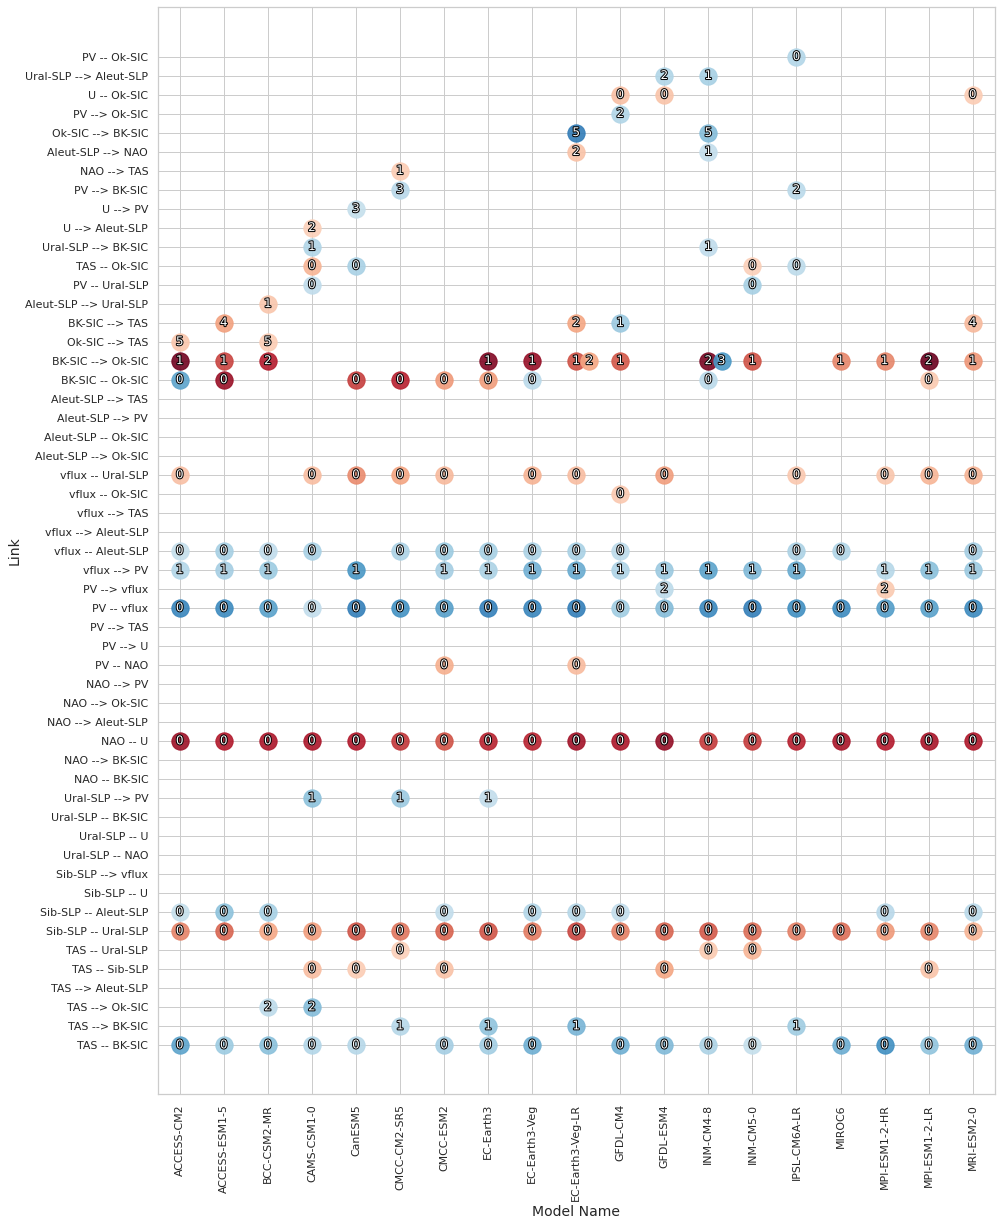

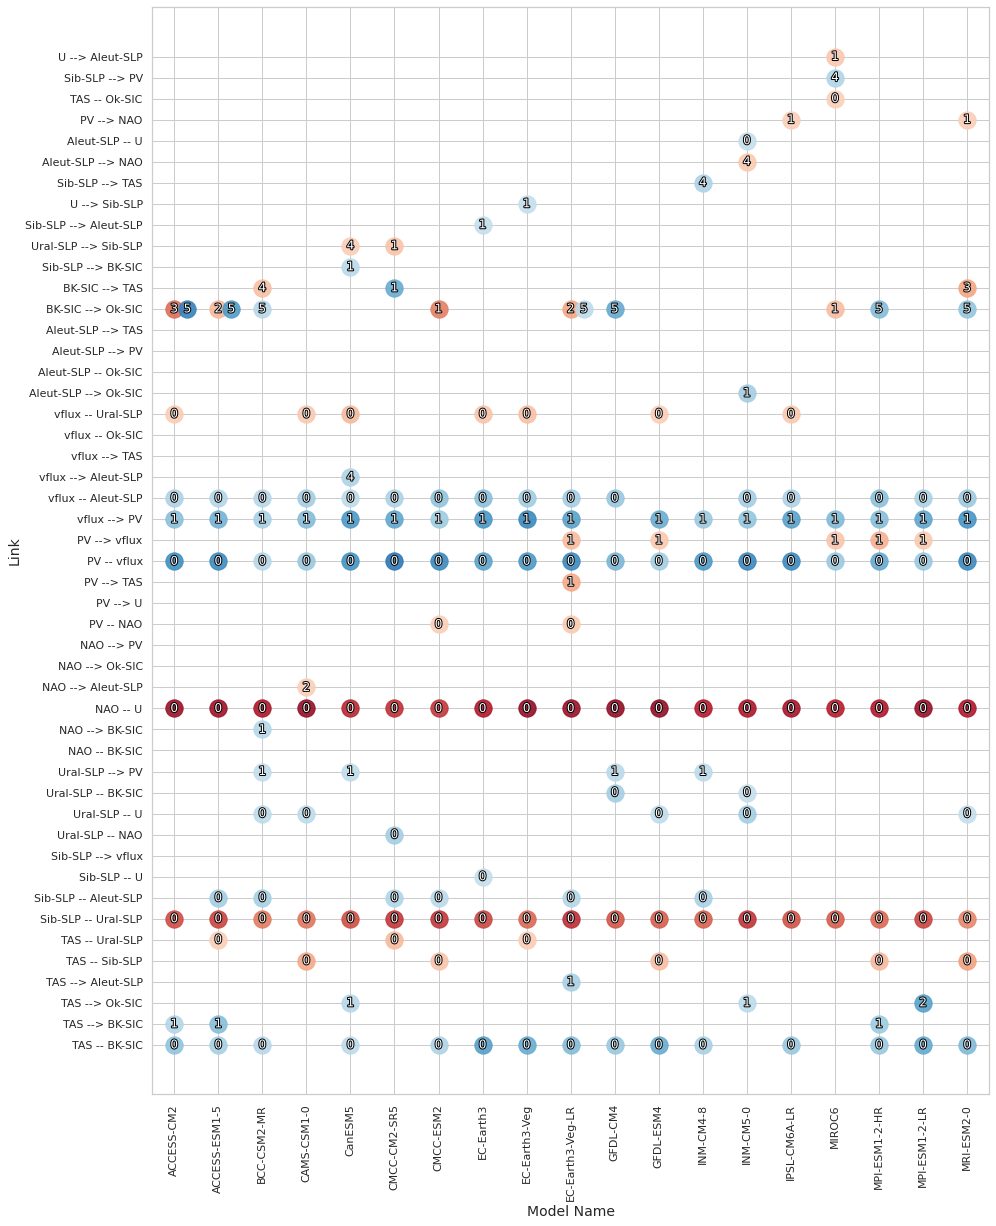

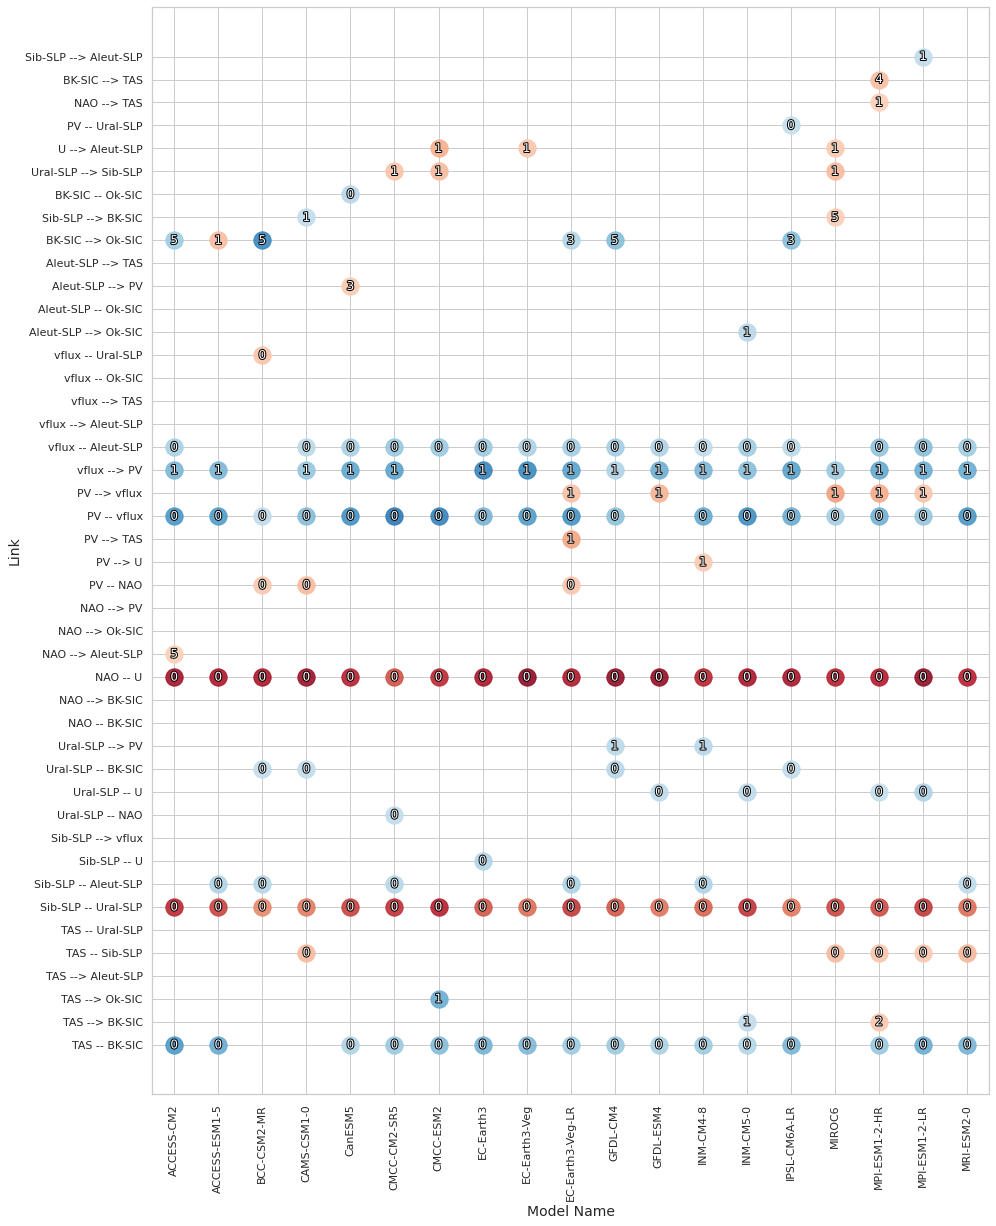

In [11]:
for masking in masking_list:
    for pc_element in pc_alpha_list:
    
        fig, ax = plt.subplots(figsize = (15, 20))
        print ("MASK: ", masking, 'PC_alpha:', pc_element)
        mycmap = matplotlib.cm.get_cmap('RdBu_r')
        ax.set_xlim([-0.5, len(dict_tigramite.keys ())-0.5])
        ax.set_xticks(np.linspace(0, len(dict_tigramite.keys ())-1, len(dict_tigramite.keys ())))
        ax.set_xticklabels(dict_tigramite.keys (),fontsize=11, rotation=90)
        ax.set_xlabel('Model Name',fontsize=14)
        ax.set_ylabel('Link',fontsize=14)
        plt.scatter (np.zeros(len (ordered_links)),ordered_links, color = 'white',s = 0)
        for n_model, key in enumerate (dict_tigramite.keys ()): 
    
            tmp_var =  correlation_dict[masking][pc_element]['plotting'][n_model]
    
            for idx, variable in enumerate (list(tmp_var.keys())): 

                if len(list(tmp_var.values ())[idx]) > 1:
                    for idn,tt in enumerate (list(tmp_var.values ())[idx]):
                        # position (pos) of nodes is needed to define if you have several links between the same actors.
                        pos = n_model + np.linspace (0, 0.3, len (list(tmp_var.values ())[idx])) 
                        pfc = plt.scatter(pos[idn], list (tmp_var.keys ())[idx], c=list(tmp_var.values ())[idx][idn][1], vmin=-1.0, vmax=1.0, marker="o",  alpha=0.9,  s = 300, cmap=mycmap)
                        text = plt.text(pos[idn], list (tmp_var.keys ())[idx], s=(list(tmp_var.values ())[idx][idn][0]), color='white',  verticalalignment='center', horizontalalignment='center') 
                        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), 
                                               path_effects.Normal()])  

                else: 
                    pfc = plt.scatter(key, variable, c=(list(tmp_var.values ())[idx][0][1]), vmin=-1.0, vmax=1.0, marker="o",  alpha=0.9, s = 300, cmap=mycmap)
                    text = plt.text(key, variable, s=(list(tmp_var.values ())[idx][0][0]), color='white',  verticalalignment='center', horizontalalignment='center') 
                    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                               path_effects.Normal()])   
        plt.savefig (base_folder + 'Summary_plots/' + today.strftime('%d%m%Y') + '/'+ masking + '/' + str (pc_element) + '/SUMMARY_presentation_1979-2019_'+masking + '_' + str (pc_element) + '.png', dpi= 120, bbox_inches = "tight")
                     